In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import os
print(os.getcwd())


c:\Users\dprih\OneDrive\Dokumen\ITS\ITS Semester 6\Capstone-Bangkit-ML\forecasting\model


In [3]:
# Memuat data
data = pd.read_csv("C:\\Users\\dprih\\OneDrive\\Dokumen\\ITS\\ITS Semester 6\\Capstone-Bangkit-ML\\scrap-data-new\\new-scrap-mean\\kentang_mean.csv")
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)
data

,no,hrg
tanggal,,
2023-01-01,0,14395.210526
2023-01-02,1,14352.421053
2023-01-03,2,14356.368421
2023-01-04,3,14439.684211
2023-01-05,4,14464.894737
...,...,...
2024-06-11,527,16898.078947
2024-06-12,528,16977.052632
2024-06-13,529,17081.447368


In [4]:
#Drop the no 
data = data.drop(columns=['no'])
data

,hrg
tanggal,
2023-01-01,14395.210526
2023-01-02,14352.421053
2023-01-03,14356.368421
2023-01-04,14439.684211
2023-01-05,14464.894737
...,...
2024-06-11,16898.078947
2024-06-12,16977.052632
2024-06-13,17081.447368


In [5]:
# Menormalisasi data harga
scaler = MinMaxScaler(feature_range=(0, 1))
data['hrg'] = scaler.fit_transform(data['hrg'].values.reshape(-1,1))

In [6]:
# Membuat dataset untuk LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# Parameter
time_step = 10

In [8]:
# Membagi data menjadi train dan test
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

In [9]:
# Membuat dataset untuk train dan test
trainX, trainY = create_dataset(train.values, time_step)
testX, testY = create_dataset(test.values, time_step)

In [10]:
# Mengubah input menjadi [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

In [11]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Menampilkan ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss=tf.keras.losses.Huber())

# Melatih model
model.fit(trainX, trainY, batch_size=1, epochs=20)

Epoch 1/20
414/414 [==============================] - 8s 8ms/step - loss: 0.0100
Epoch 2/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0021
Epoch 3/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0020
Epoch 4/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0020
Epoch 5/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0020
Epoch 6/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0017
Epoch 7/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0016
Epoch 8/20
414/414 [==============================] - 3s 7ms/step - loss: 0.0017
Epoch 9/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0015
Epoch 10/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0016
Epoch 11/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0015
Epoch 12/20
414/414 [==============================] - 3s 8ms/step - loss: 0.0015
Epoch 13/20
414/414 [====

In [13]:
# Melakukan prediksi
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

3/3 [==============================] - 0s 5ms/step


In [14]:
# Mengembalikan harga ke skala semula
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

In [15]:
# Menghitung MAPE untuk train dan test
mape_train = mean_absolute_percentage_error(trainY, train_predict) * 100
mape_test = mean_absolute_percentage_error(testY, test_predict) * 100

print(f"MAPE Train: {mape_train}%")
print(f"MAPE Test: {mape_test}%")

MAPE Train: 0.6624638801371705%
MAPE Test: 0.6966904166551514%


In [16]:

# Membuat dataframe untuk hasil prediksi train
train_predict_df = pd.DataFrame({
    'tanggal': data.index[time_step:len(train_predict) + time_step],
    'harga_asli': trainY.flatten(),
    'harga_prediksi': train_predict.flatten()
})
train_predict_df.set_index('tanggal', inplace=True)

# Membuat dataframe untuk hasil prediksi test
test_predict_df = pd.DataFrame({
    'tanggal': data.index[len(train_predict) + (time_step * 2) + 1:len(data) - 1],
    'harga_asli': testY.flatten(),
    'harga_prediksi': test_predict.flatten()
})
test_predict_df.set_index('tanggal', inplace=True)

# Menampilkan hasil prediksi train
print("Hasil Prediksi Train:")
print(train_predict_df.head())

# Menampilkan hasil prediksi test
print("Hasil Prediksi Test:")
print(test_predict_df.head())

Hasil Prediksi Train:
              harga_asli  harga_prediksi
tanggal                                 
2023-01-11  14914.473684    14627.274414
2023-01-12  15031.342105    14703.484375
2023-01-13  15107.236842    14790.644531
2023-01-14  15058.605263    14881.622070
2023-01-15  15091.500000    14953.872070
Hasil Prediksi Test:
              harga_asli  harga_prediksi
tanggal                                 
2024-03-11  16309.526316    16321.291992
2024-03-12  16237.157895    16322.244141
2024-03-13  16147.657895    16318.198242
2024-03-14  16194.578947    16299.959961
2024-03-15  16180.973684    16284.526367


In [17]:
# Prediksi harga masa depan
future_steps = 30  # jumlah langkah ke depan yang ingin diprediksi
last_sequence = data.values[-time_step:]  # ambil urutan terakhir dari data

future_predictions = []

for _ in range(future_steps):
    # Ubah bentuk input menjadi [samples, time steps, features]
    input_sequence = last_sequence.reshape((1, time_step, 1))
    next_prediction = model.predict(input_sequence)
    future_predictions.append(next_prediction[0, 0])
    
    # Perbarui urutan terakhir dengan menggeser ke kiri dan menambahkan prediksi terbaru
    last_sequence = np.append(last_sequence[1:], next_prediction)[-time_step:]

# Mengembalikan harga ke skala semula untuk prediksi masa depan
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Membuat tanggal untuk prediksi masa depan
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')

# Membuat dataframe untuk hasil prediksi masa depan
future_predict_df = pd.DataFrame({
    'tanggal': future_dates,
    'harga_prediksi': future_predictions.flatten()
})
future_predict_df.set_index('tanggal', inplace=True)

# Menampilkan hasil prediksi masa depan
print("Hasil Prediksi Masa Depan:")
print(future_predict_df.head())

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step
Hasil Prediksi Masa Depan:
            harga_prediksi
tanggal                   
2024-06-16    16983.638672
2024-06-17    17004.050781
2024-06-18    17017.125000
2024-06-19    17026.853516
2024-06-20    17034.257812


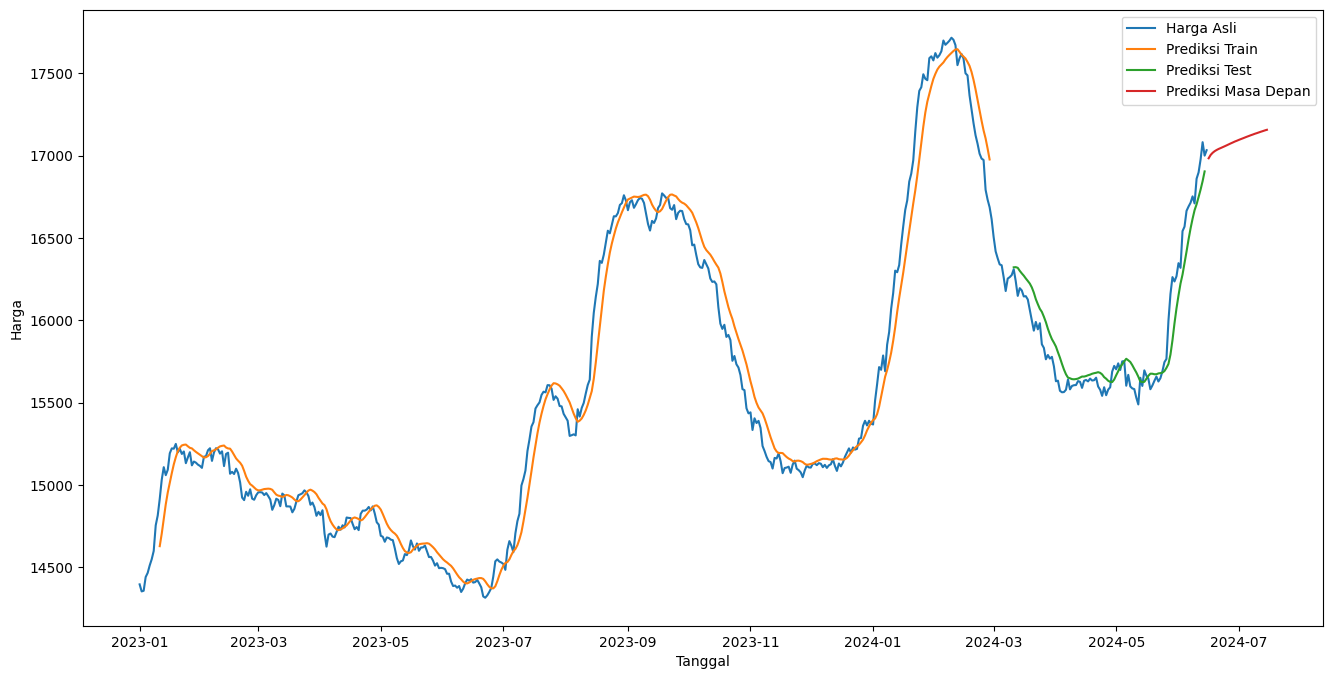

In [18]:
# Visualisasi hasil
plt.figure(figsize=(16,8))
plt.plot(data.index, scaler.inverse_transform(data['hrg'].values.reshape(-1, 1)), label='Harga Asli')
plt.plot(data.index[time_step:len(train_predict) + time_step], train_predict, label='Prediksi Train')
plt.plot(data.index[len(train_predict) + (time_step * 2) + 1:len(data) - 1], test_predict, label='Prediksi Test')
plt.plot(future_predict_df.index, future_predict_df['harga_prediksi'], label='Prediksi Masa Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.show()

## Saving the Model in Different Formats:
- Pickle

In [19]:
# import pickle

# # Save the model using Pickle
# with open('kentang_forecasting.pkl', 'wb') as file:
#     pickle.dump(model, file)

# # Load the model using Pickle
# with open('kentang_forecasting.pkl', 'rb') as file:
#     loaded_model_pickle = pickle.load(file)

- H5

In [20]:
# Save the model using H5 format
model.save('kentang_forecasting.h5')

# Load the model using H5 format
from tensorflow.keras.models import load_model
loaded_model_h5 = load_model('kentang_forecasting.h5')

- TensorFlow Saved Model

In [21]:
# # Save the model using TensorFlow SavedModel format
# model.save('saved_model/kentang_forecasting')

# # Load the model using TensorFlow SavedModel format
# loaded_model_saved = tf.keras.models.load_model('saved_model/kentang_forecasting')

- TensorFlow Lite

In [22]:
# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the TensorFlow Lite model
# with open('kentang_forecasting.tflite', 'wb') as file:
#     file.write(tflite_model)

# # Load the TensorFlow Lite model (for inference, not training)
# interpreter = tf.lite.Interpreter(model_path='kentang_forecasting.tflite')
# interpreter.allocate_tensors()

# # Getting input and output tensors
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()